In [1]:
%%html
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value=" 
Curso: Diseño y mantenimiento de instalaciones de energía solar fotovoltaica
Alumno: Francisco Manuel Roman Gamez

"></form>

In [2]:
# https://ec.europa.eu/jrc/en/PVGIS/docs/noninteractive
# https://ec.europa.eu/jrc/en/PVGIS/releases/pvgis51
# https://re.jrc.ec.europa.eu/pvg_tools/es/#MR

from flask import Flask, jsonify, render_template, request, session, json, Markup
import requests as requests

import pandas as pd # data wrangling
import datetime
from math import pi
import numpy as np
import matplotlib.pyplot as plt
from pvlib import solarposition
import base64
from io import BytesIO


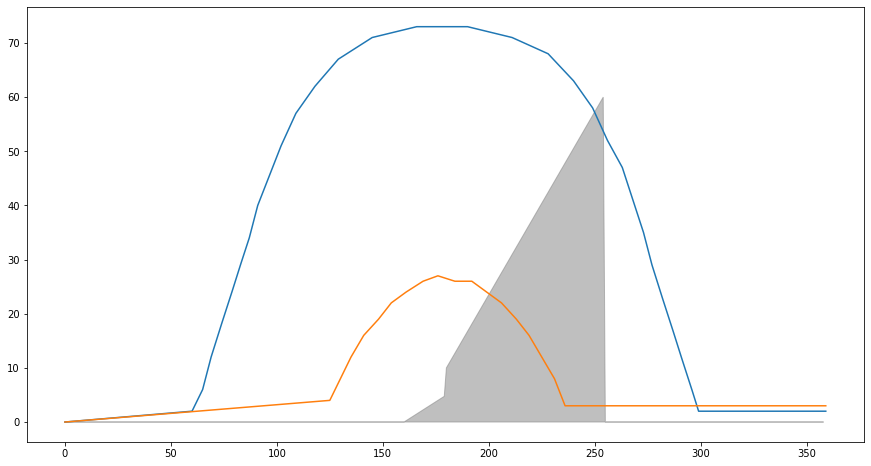

In [30]:
# p=session["p"]
p=[[-80,0],[-100,0],[-40,0],[-60,0],[-0,5],[-20,0],[0,10],[20,0],[40,0],[60,0],[80,0],[100,0]]

# Ess=session["Ess"]

# datos del navegador
latitud = 40
longitud = -4
inclinacion = 30
orientacion = 20
punto = '3,1,74,60'
Es0 = 2123.67




# \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
# pedidas con el horizonte de la figura
def horizonte(p,df):
    dfp=df.loc[p,:]
    pp=dfp.values.tolist()
    #     para qeu de igual el orden de los dos puntos
    pp.sort()
    # y pone a cero un punto delante u toro de tras para poder interpolar con los extremos a cero
    pp=([-180,0],[pp[0][0]-1,0],pp[0],pp[1],[pp[1][0]+1,0],[180,0])
    ddf=pd.DataFrame(pp)
    ddf[0]=ddf[0]+180
    # crea el perfil a cero
    d = pd.Series(np.nan, index=np.arange(360))
    # y le anade los puntos
    ii=ddf.index.tolist()
    for i in ii: 
        d.at[ddf.at[i,0]]=ddf.at[i,1]
    s=d.interpolate()
    return s
#
# tuples=[(0,0),(0,1),(1,0),(1,1),(2,0),(2,1),(3,0),(3,1),(4,0),(4,1),(5,0),(5,1),(6,0),(6,1),(7,0),(7,1)]
tuples=[(0,0),(0,1),(1,0),(1,1),(2,0),(2,1),(3,0),(3,1),(4,0),(4,1),(5,0),(5,1)]
index=pd.MultiIndex.from_tuples(tuples)

st=pd.Series(0, index=np.arange(360))
df=pd.DataFrame(p, index=index)
# session.pop('p', None) #####   !!!! ojo libera la sesion para poder y acumulando los cambios
# actualiza con el punto del front
pp = pd.DataFrame([x.split(',') for x in punto.split('\n')])
pp=pp.astype(int) 
# actualiza la tabla de puntos
df.loc[pp.at[0,0]].at[pp.at[0,1],0]=pp.at[0,2]
df.loc[pp.at[0,0]].at[pp.at[0,1],1]=pp.at[0,3]
# print(df)
p=df.values.tolist()

# para combinar en un solo perfil los perfiles de las parejas de ppuntos
puntos=list(set(index.get_level_values(0)))
for i in puntos:
    s=horizonte(i,df)
    st=st.combine(s, max, 0)


hh=st.tolist()
hh = [round(x,2) for x in hh]
hh=hh[0:359]
# ///////////////////////////////////////////////////////////////////////


# \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
# para dibujar las dos lineas de solsticio de invierno u verano
tz = 'Europe/Madrid'
lat, lon = latitud, longitud # madrid
# lat, lon = 36.664240, -4.458649 # mia
si= pd.date_range(start='2019-12-20 23:00:00', periods=48, freq='30T', tz=tz)
sv= pd.date_range(start='2019-06-20 23:00:00', periods=48, freq='30T', tz=tz)
dfv = solarposition.get_solarposition(sv, lat, lon)
# remove nighttime
dfv = dfv.loc[dfv['apparent_elevation'] > 0, :]
dfv['azimut']=dfv['azimuth']-180
# dfv.plot(kind='line',x='azimut',y='apparent_elevation',figsize=(15,10));

dfi = solarposition.get_solarposition(si, lat, lon)
dfi = dfi.loc[dfi['apparent_elevation'] > 0, :]
dfi['azimut']=dfi['azimuth']-180
# dfi.plot(kind='line',x='azimut',y='apparent_elevation',figsize=(15,10));
dfv1=dfv[['azimut','apparent_elevation']]
dfi1=dfi[['azimut','apparent_elevation']]
# solsticio de verano
ss=pd.Series(np.nan, index=np.arange(360))
dd=dfv1.rename(columns={'azimut':'x','apparent_elevation':'y'})

dd['x']=round(dd['x'],0)
xx=dd['x'].tolist()
xx=[int(i) for i in xx]
xx=[i+180 for i in xx]
# 
dd['y']=round(dd['y'],0)
yy=dd['y'].tolist()
yy=[int(i) for i in yy]
for i in range(len(xx)): 
    ss.at[xx[i]]=yy[i]
ss.at[0]=0
ss=ss.interpolate()

hsv=ss.tolist()
# solsticio de invierno
ss=pd.Series(np.nan, index=np.arange(360))
dd=dfi1.rename(columns={'azimut':'x','apparent_elevation':'y'})

dd['x']=round(dd['x'],0)
xx=dd['x'].tolist()
xx=[int(i) for i in xx]
xx=[i+180 for i in xx]
# 
dd['y']=round(dd['y'],0)
yy=dd['y'].tolist()
yy=[int(i) for i in yy]
for i in range(len(xx)): 
    ss.at[xx[i]]=yy[i]
ss.at[0]=0
ss=ss.interpolate()

hsi=ss.tolist()
fig,ax=plt.subplots(figsize=(15,8))
ax.fill(hh,color='grey',alpha=0.5)
ax.plot(hsv)
ax.plot(hsi)


# 
img = BytesIO()
plt.savefig(img, format='png')
img.seek(0)
plot_url = base64.b64encode(img.getvalue()).decode()
model_plot_horizonte = Markup('<img src="data:image/png;base64,{}">'.format(plot_url))
# plt.close()


https://re.jrc.ec.europa.eu/api/PVcalc?lat=40&lon=-4&peakpower=1&loss=0&angle=30&aspect=20&localtime=1&outputformat=json


2100.47

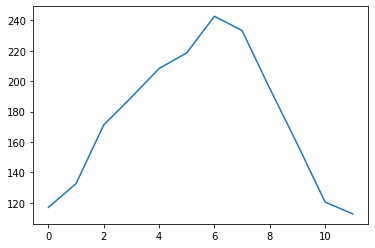

In [50]:
# Calculos
# ????????????????   irraciacion
# url="https://re.jrc.ec.europa.eu/api/DRcalc?lat="+lat+"&lon="+lon+"&month="+mes+"&global=1"

url="https://re.jrc.ec.europa.eu/api/PVcalc?lat="+str(latitud)+"&lon="+str(longitud)+"&peakpower=1&loss=0"
url=url+"&angle="+str(inclinacion) # angle Inclination angle from horizontal plane of the (fixed) PV system. 
url=url+"&aspect="+str(orientacion)    #Orientation (azimuth) angle of the (fixed) PV system, 0=south, 90=west, -90=east.
url=url+"&localtime=1"
url=url+"&outputformat=json"
print(url)
# print(url)
hh0=[0,0,0,0,0,0,0,0]
url=url+"&userhorizon="+str(hh0).strip('[]')
# print(url)
r = requests.get(url)
datas0 = r.json()
# data
# session.pop('E', None) #####   !!!! ojo libera la sesion para poder y acumulando los cambios

j=data["outputs"]["monthly"]["fixed"]
jf= json.dumps(j, indent=2)
df=pd.read_json(jf, orient='records') 
df["H(i)_m"].plot()



# energia total anual
E=datas0["outputs"]["totals"]["fixed"]["H(i)_y"]
E



# 

In [45]:
df

,month,E_d,E_m,H(i)_d,H(i)_m,SD_m
0,1,3.68,114.00,3.77,117.01,22.66
1,2,4.56,127.80,4.74,132.72,16.93
2,3,5.20,161.17,5.52,171.27,18.37
3,4,5.76,172.95,6.32,189.46,10.60
4,5,5.97,185.14,6.72,208.37,13.05
5,6,6.28,188.41,7.29,218.66,6.07
6,7,6.62,205.11,7.83,242.73,5.53
7,8,6.40,198.33,7.53,233.30,4.17
8,9,5.71,171.17,6.51,195.20,8.87
9,10,4.67,144.77,5.11,158.52,13.46


In [35]:

# calculo de las perdidas

In [37]:

url=url+"&userhorizon="+str(hh).strip('[]')
# print(url)
r = requests.get(url)
datas9 = r.json()
# session.pop('E', None) #####   !!!! ojo libera la sesion para poder y acumulando los cambios
E=datas9["outputs"]["totals"]["fixed"]["H(i)_y"]
E




# session.pop('P', None) #####   !!!! ojo libera la sesion para poder y acumulando los cambios
print(Es0)
Es0=float(Es0)
P=100-E*100/Es0
P=round(P,2)
# 
# calculo de las perdidas


2123.67


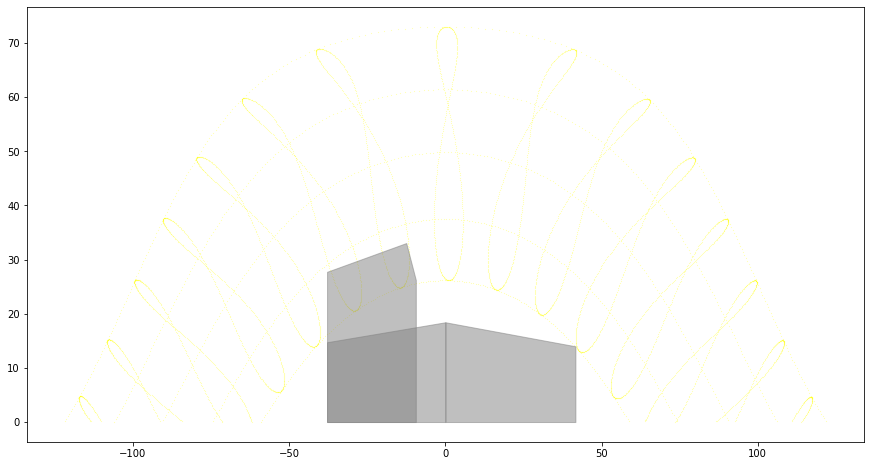

In [7]:
# proyecto='ua92-te2-03'
proyecto='ua92-te2-03'
ciudad ='Valencia'
beta=35
alfa=0

# from numpy import *
import pandas as pd
import numpy as np
# np.warnings.filterwarnings('ignore')
%matplotlib inline
np.warnings.filterwarnings('ignore')
from numpy import ones,vstack
from numpy.linalg import lstsq
import matplotlib.pyplot as plt
from pvlib import solarposition

# ///////////////////////////////////////////////
# ///////////////////////////////////////////////
# ///////////////////////////////////////////////
## analema

# ?grafico de posiciones

tz = 'Europe/Madrid'
lat, lon = 40.416644, -3.703792 # madrid
start='2019-01-01 00:00:00'
end='2020-01-01'
# analema
analema=pd.date_range(start+' 00:17:00', end, closed='left', freq='H', tz=tz)
# solsticios y quinocios
dias=pd.date_range(start, start, freq='1min', tz=tz)
# for date in pd.to_datetime(['2019-03-21','2019-04-21', '2019-06-21', '2019-10-27','2019-12-21']):
for date in pd.to_datetime(['2019-03-21','2019-04-21', '2019-06-21', '2019-10-25','2019-12-21']):
    dia = pd.date_range(date, date+pd.Timedelta('24h'), freq='3min', tz=tz)
    dias=dias.union(dia)
# todo    
T=analema.union(dias)
dfg = solarposition.get_solarposition(T, lat, lon)
dfg = dfg.loc[dfg['apparent_elevation'] > 0, :]
dfg = dfg.rename(columns={'apparent_elevation': 'elevacion'})
dfg["azimut"]=dfg["azimuth"]-180
# dfg
# dfg.plot(kind='scatter',x='azimuth',y='apparent_elevation',figsize=(15,10));
# calculos de los 8 punos del cubo y paso a polares

# ///////////////////////////////////////////////
# ///////////////////////////////////////////////
# ///////////////////////////////////////////////
# ///////////////////////////////////////////////



def pointIsOnLine(m, c, x, y): 
    if (y >= ((m * x) + c)):  
        return True;  
    return False;  


def pp(q):
    # def sombra(q):
    p=q[:,:3]
    v=q[:,3:6]
    t1=[0,0,0,0,1,1,1,1]
    t2=[0,0,1,1,0,0,1,1]
    t3=[0,1,0,1,0,1,0,1]
    t=np.array([t1,t2,t3])
    # 
    ones=np.eye(3, dtype=int)
    vv=v*ones
    tt=np.dot(vv,t)
    pp=np.transpose(p)+tt
    df = pd.DataFrame(pp).T
    df.columns=['s','o','h']
    df['azimut']=round(np.arctan(df.o/df.s)*180/np.pi,2)
#     sii esta en el tercer cuadrante, al amanecer
    if (df.iloc[0]['s'] < 0) & (df.iloc[0]['o'] < 0):
        df['azimut']=-180+df['azimut']
    if (df.iloc[0]['s'] < 0) & (df.iloc[0]['o'] > 0):
        df['azimut']=180+df['azimut']
    df['elevacion']=round(np.arctan(df.h/(df.s**2+df.o**2)**(1/2))*180/np.pi,2)
    df.set_index('azimut')
    df=df.sort_values(by=['elevacion'],ascending=False)

    df=df[0:3]
    df=df.sort_values(by=['azimut'],ascending=True)

    # # ax = df.plot.area()
    x1=df.iloc[0]['azimut']
    y1=df.iloc[0]['elevacion']
    x2=df.iloc[2]['azimut']
    y2=df.iloc[2]['elevacion']
    x=df.iloc[1]['azimut']
    y=df.iloc[1]['elevacion']
    # [x1,y1,x2,y2,x,y]
    points = [(x1,y1),(x2,y2)]
    x_coords, y_coords = zip(*points)
    A = np.vstack([x_coords,np.ones(len(x_coords))]).T
    m, c = lstsq(A, y_coords)[0]


    points = [(x1,y1),(x2,y2)]
    x_coords, y_coords = zip(*points)
    A = np.vstack([x_coords,np.ones(len(x_coords))]).T
    m, c = lstsq(A, y_coords)[0]


    # Driver code  
    # x = 2; y = 3;  

    if not (pointIsOnLine(m, c, x, y)):  
        df=df.drop(df.index[1])
    return df

# ///////////////////////////////////////////////
# ///////////////////////////////////////////////
# ///////////////////////////////////////////////
# figura
df=pd.DataFrame()
# 
fig,ax=plt.subplots(figsize=(15,8))


# import matplotlib.image as mpimg
# image = mpimg.imread('./sombras2.png')
# ax.imshow(image,aspect='auto', extent=(-130,130,0,80), alpha=0.5, zorder=-1)

f=dfg[["azimut","elevacion"]].copy()
x=f["azimut"].tolist()
y=f["elevacion"].tolist()
ax.scatter(x,y,s=0.01,color='yellow')


# q=np.array([[9, -7, 0,7,7,3]])
# f=pp(q)
# x=f["azimut"].tolist()
# y=f["elevacion"].tolist()
# ax.fill_between(x,0,y, color='grey',alpha=0.5)


df=pd.DataFrame()
df=pd.read_csv("tablas/sombras_edificios.csv")
df=df[(df.proyecto == proyecto)]
df=df.drop(['proyecto'], axis=1)
cubos=df.to_numpy()
ff=pd.DataFrame()
for row in cubos:
    row=np.array([row])
    q=row
    f=pp(q)
    ff=ff.append(f)
    x=f["azimut"].tolist()
    y=f["elevacion"].tolist()
    ax.fill_between(x,y, color='grey',alpha=0.5)
#     ax.plot(x,y, color='grey',alpha=0.5)

# maquillado de los puntos para imprimir
# ff = ff.rename(columns={'azimut':"$\alpha $"})
ff=ff.drop(['s','o','h'], axis=1)



import os
# os.remove("plt.png")

# fig.savefig('plt.png')
# plt.close()

In [8]:
# ///////////////////////////////////////////////
# ///////////////////////////////////////////////
# ///////////////////////////////////////////////


# calculo de las sombras
import pandas as pd
import numpy as np
# pesos


dfi=pd.DataFrame()
dfo=pd.DataFrame()


#  tasbla de irradiacion
s=pd.DataFrame()
s=pd.read_csv('tablas/sombras_coeficientes.csv', index_col=0, header=None).T
ab=s.loc[(s['a'] == str(alfa))&(s['b'] == str(beta))]
dfi  = ab.drop(['a', 'b'], axis=1)

d = pd.DataFrame(np.zeros((14, 4)))

dfi=dfi.reindex(index=dfi.index[::-1])
dfi=dfi.set_index('porc')

# tabla de ocultacon
dfo=pd.read_csv('tablas/sombras_ocultacion.csv', index_col=0, header=0)
dfo=dfo[dfo['proyecto']==proyecto]
dfo  = dfo.drop(['proyecto'], axis=1)


# marcar las porciones afectadas
def highlight(value):
    return dfo.applymap(lambda x: 'color: red' if x*10 else '')
dfs=dfi.style.apply(highlight, axis=None)

# las perdidas parciales
p=dfi.values.astype(float)*dfo.values.astype(float)/100
# solo para visualizarla tabla
dfp=dfi.copy()
dfp.loc[::]=np.array(p)
# para calcular las perdidas totales como la suma de todas las parciales
pp=np.cumsum(np.reshape(p,56))
pt=pp[len(pp)-1]

## 3.- Calcula las perdidas por sombras del ejercicio cuyo dibujo se expone, sabiendo que la ciudad donde se encuentra el edificio es Madrid y módulos a 35 º con la horizontal.

![]( 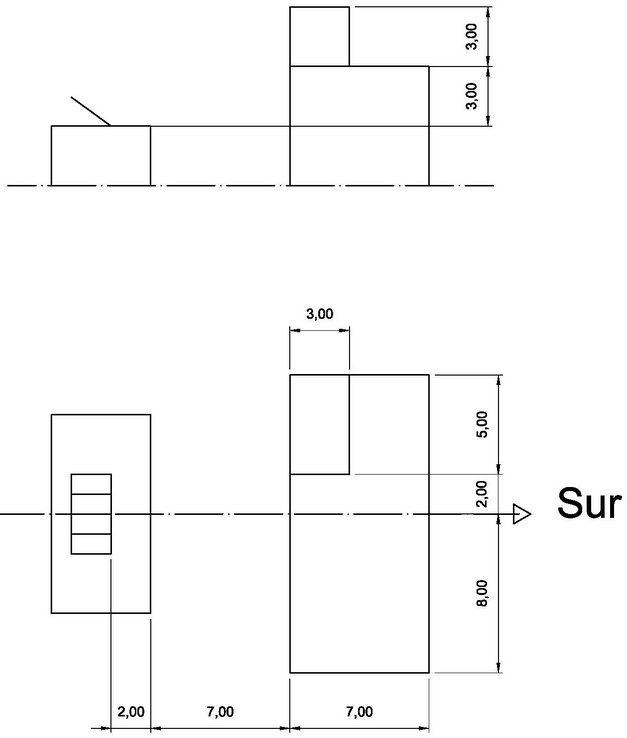)

## Respuesta

{{model_plot_horizonte}}
Se utiliza el  método  descrito en el Pliego de Condiciones Técnicas deInstalaciones Conectadas a Red (PCT-C-REV - julio 2011),

Segun el cual tales pérdidas se expresan como porcentaje de la radiación solar global que incidiría sobre la mencionada superficie de no existir sombra alguna. 

### Obtención del perfil de obstáculos 
Localización  de  los  principales  obstáculos  que  afectan  a  la  superficie,  en  términos  de  sus  coordenadas de posición azimut ,$\angle \alpha$ ,(ángulo de desviación con respecto a la dirección Sur) y elevación,$\angle \beta $, (ángulo de inclinación con respecto al plano horizontal). 

En nuestro caso a partir de la figura, tomando como origen de coordenadas

* C :centro de los captadores

Se define el sistema de coordenadas rectangulares 
* S (m) : horizontal sur. ( $\overrightarrow{CP}_S$) 
* O (m) : horizonal oeste.( $\overrightarrow{CP}_O$) 
* H (m) : vertical.( $\overrightarrow{CP}_H$) 

de donde se obienen:

$$
\alpha=\arctan \frac{O}{S}        \\
\beta =\arctan \frac{H}{\sqrt{S^2+O^2}}
$$


{{ff}}

Representados en el diagrama de la figura:

![alt text](plt.png "Title")

Se excoge como  referencia de irradiacion anual (%) la tabla $H_{\% irradiacion,p}$, para cada porcion, segun los ángulos de inclinación,$\beta_s$  y orientación,$\alpha_s$ 

* $\beta_s$={{beta}}$^o$
* $\alpha_s$={{alfa}}$^o$

{{dfs}}

Usando para aquellas porciones que resulten  total  o  parcialmente  ocultas  por  el  perfil  de  obstáculos  representado, los valores: 
* $\% ocultacion \in [0.25, 0.50, 0.75,1]$
se tiene la tabla $O_{\%ocultacion,p}$
{{dfo}}

combinando ambas tablas

* $Pérdidas_{\%sombreado,p}=H_{\% irradiacion,p} \cdot  O_{\%ocultacion,p}$

{{dfp}}

* $Pérdidas_{\%sombreado,Total}=\sum_{p} Pérdidas_{\%sombreado,p}$ 
> $Pérdidas_{\%sombreado,Total}=${{pt}} %

In [9]:
%%html
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value=" 
Curso: Diseño y mantenimiento de instalaciones de energía solar fotovoltaica
Alumno: Francisco Manuel Roman Gamez

"></form>